---

# Biotite documentation

---
https://www.biotite-python.org/

目标
- 梳理tutorial的基本内容，熟悉一下biotite处理生物大分子对象的底层逻辑
- 结合ESM的模块，生成自己用于数据处理的code

biotite的基本内容:
1. Searching and fetching data from biological databases
2. Reading and writing popular sequence/structure file formats
3. Analyzing and editing sequence/structure data
4. Visualizing sequence/structure data
5. Interfacing external applications for further analysis

biotite和biopython最大的区别: biotite在内部将大部分对象存储在numpy ndarray的形式，更方便外部索引和加速


## sequence subpackage

## structure subpackage

This subpackage enables handling of 3D structures of biomolecules. Simplified, a structure is represented by a list of atoms and their properties, based on ndarray objects. Optionally, this representation can be enriched with chemical bond information. Biotite supports different structure formats, including the ones provided by the RCSB and Gromacs trajectory formats. The subpackage offers a wide range of functions for atom filtering, coordinate transformations, angle and bond measurements, accessible surface area calculation, structure superimposition and more.

`biotite.structure`是处理结构的模块，主要包含三个部分，`Atom,AtomArray,AtomArrayStack`，分别对应了单个原子，一个model的所有原子，所有model的所有原子。这些模块的底层都是用numpy来实现存储的

### Creating structures

In [1]:
import biotite.structure as struc
atom1 = struc.Atom([0,0,0],chain_id="A",res_id=1,res_name="GLY",atom_name="N",element="N")
atom2 = struc.Atom([0,1,1],chain_id="A",res_id=1,res_name="GLY",atom_name="CA",element="C")
atom3 = struc.Atom([0,0,2],chain_id="A",res_id=1,res_name="GLY",atom_name="C",element="C")

第一个参数是坐标，在内部被转化为`numpy ndarray`，其余参数是注释，包括了chain ID,residue Id, residue name, insertion code, atom name, element, hetero(whethere the atom is not in protein/nucleotide chain)，如果在创建atom的时候忽视了这些注释那么就会得到默认值，The mandatory annotation categories 来自PDB格式的ATO吗和HETATM格式记录。也可以任意指定annotation比如b_factor和带电量等，具体可以参考 https://www.biotite-python.org/apidoc/biotite.structure.html 。

如果想要控制整个大分子结构，一般更常见的是使用AtomArray或者AtomArrayStack。AtomArray内部并不是用数组来存储相关的内容，而是对每一个annotation和坐标存储一个ndarray (ndarray 是numpy array的数据类型，dtpye为str时用来存储annotation)

In [2]:
import numpy as np
array = struc.array([atom1,atom2,atom3])
print(f"Chain ID:{array.chain_id}")
print(f"Residue ID:{array.res_id}")
print(f"Atom name:{array.atom_name}")
print(f"Coordinates:{array.coord}")
print(array)

Chain ID:['A' 'A' 'A']
Residue ID:[1 1 1]
Atom name:['N' 'CA' 'C']
Coordinates:[[0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 2.]]
    A       1  GLY N      N         0.000    0.000    0.000
    A       1  GLY CA     C         0.000    1.000    1.000
    A       1  GLY C      C         0.000    0.000    2.000


`biotite.structure.array()` 内置函数输入一个包含`Atom instance`的可迭代对象，来生成`AtomArray()`，由于`AtomArray()`本身就是一个可迭代对象，你甚至可以用`AtomArray()`来生成另一个`AtomArray()`。注意到生成的annotation ndarray size=(n,)，coordinate ndarray size=(n,3)

In [3]:
# 根据annotation来numpy式的过滤coordinate
array.chain_id[:] = "B"
array.coord[array.chain_id == "B"] = np.array([0.0,0.0,0.0])
# It is also possible to replace an entire annotation with another array
array.res_id = np.array([1,2,3])
print(array)

    B       1  GLY N      N         0.000    0.000    0.000
    B       2  GLY CA     C         0.000    0.000    0.000
    B       3  GLY C      C         0.000    0.000    0.000


可以利用`array.add_annotation()` or `array.set_annotation()`来为array增添一个annotation

In [4]:
array.add_annotation("foo", dtype=bool)
array.set_annotation("bar", [1, 2, 3])
print(array.foo)
print(array.bar)

[False False False]
[1 2 3]


为了处理每个原子出现在不同位置的情况，比如在NMR结构中可能会有多个model，或者是MD traj会有成千上万个轨迹，此时就需要`AtomArrayStack` object来处理这种情况。annotation仍然是一个长度为n的 object array，但是coordinates就是一个(m,n,3)-shaped ndarray

In [5]:
stack = struc.stack([array,array.copy()])
print(stack)

Model 1
    B       1  GLY N      N         0.000    0.000    0.000
    B       2  GLY CA     C         0.000    0.000    0.000
    B       3  GLY C      C         0.000    0.000    0.000

Model 2
    B       1  GLY N      N         0.000    0.000    0.000
    B       2  GLY CA     C         0.000    0.000    0.000
    B       3  GLY C      C         0.000    0.000    0.000




### Loading structures from file

根据`biotite.structure.io.pdb`里的PDBFile包来进行io操作

In [6]:
import biotite.structure.io.pdb as pdb
import biotite.database.rcsb as rcsb
from tempfile import gettempdir, NamedTemporaryFile

pdb_file_path = rcsb.fetch("1l2y", "pdb", gettempdir())
pdb_file = pdb.PDBFile.read(pdb_file_path)
tc5b = pdb_file.get_structure()
print(type(tc5b).__name__)
print(tc5b.stack_depth())
print(tc5b.array_length())
print(tc5b.shape)

AtomArrayStack
38
304
(38, 304)


利用`PDBFile` class来保存结构

In [7]:
pdb_file = pdb.PDBFile()
pdb_file.set_structure(tc5b)
temp_file = NamedTemporaryFile(suffix=".pdb", delete=False)
pdb_file.write(temp_file.name)
temp_file.close()

注意到使用`biotite.structure.io.pdb`模块进行io操作时，除了原子的基本信息，其余信息比如（二级结构、作者、解析日期）等并不会保留，所以更好等建议是使用PDBx/mmCIF格式来进行io操作，biotite可以通过类似字典的方式来保存信息，只是要用到`PDBxFile` class

In [8]:
import biotite.structure.io.pdbx as pdbx
cif_file_path = rcsb.fetch("1l2y","cif",gettempdir())
cif_file = pdbx.PDBxFile.read(cif_file_path)

In [9]:
tc5b = pdbx.get_structure(cif_file,model=1)
pdbx.set_structure(cif_file, tc5b)


`get_structure()`是来创建AtomArrayStack对象（即使只有1个model），如果想要制定AtomArray，可制指定用第几个model。`set_structure()`是为一个PDB,mmCIF文件对象来指定结构

如果想要解析一个batch许多结构文件或loading很大的文件，使用PDB或者mmCIF文件可能比较慢，可以使用MMTF文件格式，MMTF是通过二进制文件来表示结构，信息与PDB和mmCIF相同。

### Array indexing and filtering

In [10]:
from tempfile import gettempdir
import biotite.structure as struc
import biotite.database.rcsb as rcsb
import biotite.structure.io as strucio

file_path = rcsb.fetch("1l2y", "mmtf", gettempdir())
stack = strucio.load_structure(file_path)
print(type(stack).__name__)
print(stack.shape)
# Get the third model
array = stack[0]
print(type(array).__name__)
print(array.shape)
# Get the fifth atom
atom = array[0]
print(type(atom).__name__)
print(atom.shape)

AtomArrayStack
(38, 304)
AtomArray
(304,)
Atom
()


atom array的索引机制和ndarray完全一样，通过single value索引AtomArrayStack->AtomArray->Atom。shape属性和ndarray对象的shape属性一样，`stack_depth()`和`array_length()`可以用来看有多少个model和原子

In [11]:
# get the first atom
atom = array[0]

# get the third and the third atom
subarray = array[[0,2]]

# get a subarray containing a range of atoms using slices
subarray = array[100:200]

# Filter all carbon atoms in resiude1
subarray = array[(array.element == "C") & (array.res_id == 1)]
# Filter all atoms where the X-coordinate is smaller than 2
subarray = array[array.coord[:,0] < 2]

In [12]:
array.coord.shape

(304, 3)

In [13]:
backbone = array[struc.filter_backbone(array)]
print(backbone.atom_name)

['N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA'
 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N'
 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C'
 'N' 'CA' 'C' 'N' 'CA' 'C' 'N' 'CA' 'C']


### Representing Bonds

In [14]:
from tempfile import gettempdir
import biotite.structure as struc

array = struc.array([
    struc.Atom([0,0,0], atom_name="N"),
    struc.Atom([0,0,0], atom_name="CA"),
    struc.Atom([0,0,0], atom_name="C"),
    struc.Atom([0,0,0], atom_name="CB")
])
print("Atoms:", array.atom_name)

bond_list = struc.BondList(
    array.array_length(),
    np.array([[1,0], [1,2], [1,3]])
)
print("Bonds (indices):")
print(bond_list.as_array())

Atoms: ['N' 'CA' 'C' 'CB']
Bonds (indices):
[[0 1 0]
 [1 2 0]
 [1 3 0]]


In [15]:
print("Bonds (atoms names):")
print(array.atom_name[bond_list.as_array()[:, :2]])

Bonds (atoms names):
[['N' 'CA']
 ['CA' 'C']
 ['CA' 'CB']]


In [16]:
ca_bonds, ca_bond_types = bond_list.get_bonds(1)
print("Bonds of CA:", array.atom_name[ca_bonds])

Bonds of CA: ['N' 'C' 'CB']


注意到内部的化学键存储的方式类似于一个由链表组成的列表(`biotite.structure.BondList.as_array()`)，理论上这是最节省空间的图的表示方法，一共会返回一个`(N,3)`的ndarray, N表示原子之间一共有多少条边, 3列中的前两列由小到大表示边的索引，第三列表示边的类型`BondType`, 0代表BondType.ANY，表示边没定义。

注意到虽然边是用ndarray定义的，但是索引的方式比较奇怪，索引需要对atom_array进行索引，以删除C原子所在的边为例子

In [17]:
mask = (array.atom_name != "C")
sub_array = array[mask]
sub_bond_list = bond_list[mask]
print("Atoms:", sub_array.atom_name)
print("Bonds (indices):")
print(sub_bond_list.as_array())
print("Bonds (atoms names):")
print(sub_array.atom_name[sub_bond_list.as_array()[:, :2]])


Atoms: ['N' 'CA' 'CB']
Bonds (indices):
[[0 1 0]
 [1 2 0]]
Bonds (atoms names):
[['N' 'CA']
 ['CA' 'CB']]


### Connecting atoms and bonds

一旦创建了atom array之后只需要调用`array.bond=bond_list`就能够显示的将定义的bond_list关联到atom的属性，这样每次对array索引时，边也会自动索引

In [18]:
array.bonds = bond_list
sub_array = array[array.atom_name != "C"]
print("Bonds (atoms names):")
print(sub_array.atom_name[sub_array.bonds.as_array()[:, :2]])

Bonds (atoms names):
[['N' 'CA']
 ['CA' 'CB']]


### Structure manipulation

直接读取结构文件后manipulate annotation和坐标

In [19]:
from tempfile import gettempdir
import biotite.database.rcsb as rcsb
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import numpy as np

file_path = rcsb.fetch("1l2y", "mmtf", gettempdir())
mmtf_file = mmtf.MMTFFile.read(file_path)
structure = mmtf.get_structure(mmtf_file, model=1)
print("Before:")
print(structure[structure.res_id == 1])
print()
structure.coord += 100
print("After:")
print(structure[structure.res_id == 1])

Before:
    A       1  ASN N      N        -8.901    4.127   -0.555
    A       1  ASN CA     C        -8.608    3.135   -1.618
    A       1  ASN C      C        -7.117    2.964   -1.897
    A       1  ASN O      O        -6.634    1.849   -1.758
    A       1  ASN CB     C        -9.437    3.396   -2.889
    A       1  ASN CG     C       -10.915    3.130   -2.611
    A       1  ASN OD1    O       -11.269    2.700   -1.524
    A       1  ASN ND2    N       -11.806    3.406   -3.543
    A       1  ASN H1     H        -8.330    3.957    0.261
    A       1  ASN H2     H        -8.740    5.068   -0.889
    A       1  ASN H3     H        -9.877    4.041   -0.293
    A       1  ASN HA     H        -8.930    2.162   -1.239
    A       1  ASN HB2    H        -9.310    4.417   -3.193
    A       1  ASN HB3    H        -9.108    2.719   -3.679
    A       1  ASN HD21   H       -11.572    3.791   -4.444
    A       1  ASN HD22   H       -12.757    3.183   -3.294

After:
    A       1  ASN N    

除了直接对坐标和注释进行变化（存储的本质都是numpy.ndarray），还可以通过一些transformation函数，比如通过`rotate()`对x-,y-,z-进行旋转

In [20]:
structure = mmtf.get_structure(mmtf_file, model=1)
print("Before:")
print(structure[structure.res_id == 1])
print()
# Rotation about z-axis by 90 degrees
structure = struc.rotate(structure, [0, 0, np.deg2rad(90)])
print("After:")
print(structure[structure.res_id == 1])

Before:
    A       1  ASN N      N        -8.901    4.127   -0.555
    A       1  ASN CA     C        -8.608    3.135   -1.618
    A       1  ASN C      C        -7.117    2.964   -1.897
    A       1  ASN O      O        -6.634    1.849   -1.758
    A       1  ASN CB     C        -9.437    3.396   -2.889
    A       1  ASN CG     C       -10.915    3.130   -2.611
    A       1  ASN OD1    O       -11.269    2.700   -1.524
    A       1  ASN ND2    N       -11.806    3.406   -3.543
    A       1  ASN H1     H        -8.330    3.957    0.261
    A       1  ASN H2     H        -8.740    5.068   -0.889
    A       1  ASN H3     H        -9.877    4.041   -0.293
    A       1  ASN HA     H        -8.930    2.162   -1.239
    A       1  ASN HB2    H        -9.310    4.417   -3.193
    A       1  ASN HB3    H        -9.108    2.719   -3.679
    A       1  ASN HD21   H       -11.572    3.791   -4.444
    A       1  ASN HD22   H       -12.757    3.183   -3.294

After:
    A       1  ASN N    

### Structure analysis

最重要的分析结构的工具，可以有以下功能
- bond angle
- length mearsurements : `struc.distance()`
- accessible surface area
- secondary structure
- radius gyration

In [21]:
from tempfile import gettempdir
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.database.rcsb as rcsb

file_path = rcsb.fetch("1l2y", "mmtf", gettempdir())
stack = strucio.load_structure(file_path)
# Filter only CA atoms
stack = stack[:, stack.atom_name == "CA"]

# Calculate distance between first and second CA in first frame
array = stack[0]
print("Atom to atom:", struc.distance(array[0], array[1]))

# Calculate distance between the first atom
# and all other CA atoms in the array
print("Array to atom:")
array = stack[0]
print(struc.distance(array[0], array))

array = stack[0]
print(struc.distance(array[0], array))
# Calculate pairwise distances between the CA atoms in the first frame
# and the CA atoms in the second frame
print("Array to array:")
print(struc.distance(stack[0], stack[1]))

print("Stack to atom:")
print(struc.distance(stack, stack[0,0]).shape)
# And finally distances between two adjacent CA in the first frame
array = stack[0]
print("Adjacent CA distances")
print(struc.distance(array[:-1], array[1:]))


Atom to atom: 3.876399
Array to atom:
[ 0.         3.876399   5.5766597  5.038891   6.316409   8.766815
  9.908135  10.614817  12.890331  14.806679  13.5011635 16.87541
 18.723566  17.224289  19.111933  16.193     15.514756  12.377812
 10.445933  12.058967 ]
[ 0.         3.876399   5.5766597  5.038891   6.316409   8.766815
  9.908135  10.614817  12.890331  14.806679  13.5011635 16.87541
 18.723566  17.224289  19.111933  16.193     15.514756  12.377812
 10.445933  12.058967 ]
Array to array:
[3.4344199  0.37241507 0.22178602 0.10823133 0.15207201 0.17017055
 0.22572783 0.47650498 0.29493213 0.1548351  0.2832347  0.40683934
 0.1355508  0.3676874  0.46464393 0.57544243 0.33707416 0.25703317
 0.34762198 0.38818687]
Stack to atom:
(38, 20)
Adjacent CA distances
[3.876399  3.8605015 3.87147   3.8455799 3.8666048 3.8585181 3.8818028
 3.860987  3.8909183 3.8635552 3.8862703 3.8756127 3.8746684 3.8655493
 3.8662775 3.8776622 3.8603828 3.8582468 3.8642192]


计算angle和dihedral

In [22]:
# Calculate angle between first 3 CA atoms in first frame
# (in radians)
print("Angle:", struc.angle(array[0],array[1],array[2]))
# Calculate dihedral angle between first 4 CA atoms in first frame
# (in radians)
print("Dihedral angle:", struc.dihedral(array[0],array[1],array[2],array[4]))

Angle: 1.6098709
Dihedral angle: 1.4903792


Text(0, 0.5, '$\\psi$')

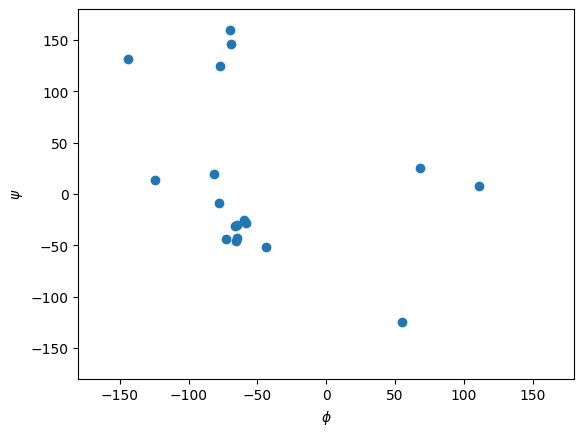

In [23]:
import matplotlib.pyplot as plt
import numpy as np

array = strucio.load_structure(file_path)[0]
phi, psi, omega = struc.dihedral_backbone(array)
plt.plot(phi * 360/(2*np.pi), psi * 360/(2*np.pi),
        marker="o", linestyle="None")
plt.xlim(-180,180)
plt.ylim(-180,180)
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

### Comparing structures -- RMSD,RMSF

RMSD for each model to first model:
[0.         0.7842643  1.0075767  0.5518028  0.8066345  1.0606678
 0.8738371  0.6260641  1.0057656  0.81440794 0.876283   1.353859
 0.93277985 0.8760094  0.99357325 0.40626574 0.31801927 1.1838906
 1.2347708  0.89114463 0.5553653  0.73639375 0.7856738  1.1019256
 0.67228884 1.1605636  0.98213965 1.2280884  0.79269636 0.8685473
 0.9386668  0.8356571  0.61650354 0.97335416 1.0322398  0.5555665
 1.1517522  0.8558534 ]


Text(0, 0.5, 'RMSF')

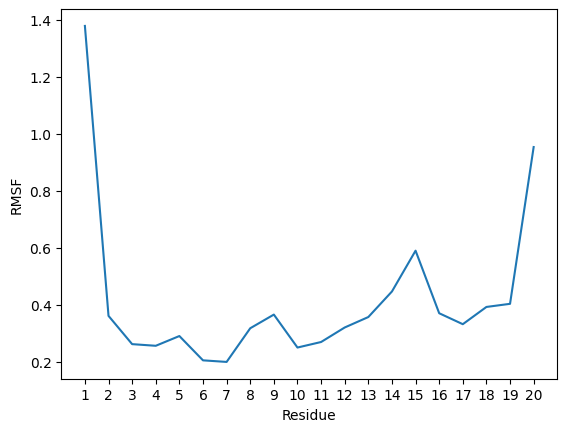

In [34]:
stack = strucio.load_structure(file_path)
# We consider only CA atoms
stack = stack[:, stack.atom_name == "CA"]
# Superimposing all models of the structure onto the first model
stack, transformation_tuple = struc.superimpose(stack[0], stack)
print("RMSD for each model to first model:")
print(struc.rmsd(stack[0], stack))
# Calculate the RMSF relative to the average of all models
rmsf = struc.rmsf(struc.average(stack), stack)
# Plotting stuff
plt.plot(np.arange(1,21), rmsf)
plt.xlim(0,21)
plt.xticks(np.arange(1,21))
plt.xlabel("Residue")
plt.ylabel("RMSF")

### Calculating accessible surface area

Another interesting value for a protein structure is the solvent accessible surface area (SASA) that indicates whether an atom or residue is on the protein surface or buried inside the protein. The function sasa() approximates the SASA for each atom. Then we sum up the values for each residue, to get the residue-wise SASA.

Besides other parameters, you can choose between different Van-der-Waals radii sets: Prot0r, the default set, is a set that defines radii for non-hydrogen atoms, but determines the radius of an atom based on the assumed amount of hydrogen atoms connected to it. Therefore, ProtOr is suitable for structures with missing hydrogen atoms, like crystal structures. Since the structure of TC5b was elucidated via NMR, we can assign a radius to every single atom (including hydrogens), hence we use the Single set.



Text(0, 0.5, 'SASA')

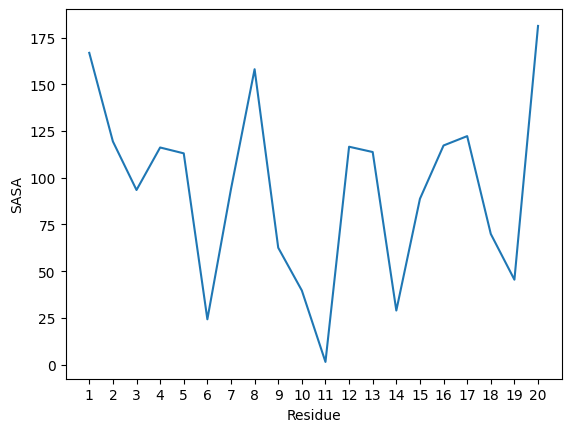

In [43]:
array = strucio.load_structure(file_path)[0]
# The following line calculates the atom-wise SASA of the atom array
atom_sasa = struc.sasa(array, vdw_radii="Single")
# Sum up SASA for each residue in atom array
res_sasa = struc.apply_residue_wise(array, atom_sasa, np.sum)
# Again plotting stuff
plt.plot(np.arange(1,21), res_sasa)
plt.xlim(0,21)
plt.xticks(np.arange(1,21))
plt.xlabel("Residue")
plt.ylabel("SASA")

### Secondary structure determination
Biotite can also be used to assign secondary structure elements (SSE) to a structure with the annotate_sse() function. An 'a' means alpha-helix, 'b' beta-sheet, and 'c' means coil.

In [44]:
array = strucio.load_structure(file_path)[0]
# Estimate secondary structure
sse = struc.annotate_sse(array, chain_id="A")
# Pretty print
print("".join(sse))

caaaaaaaaccccccccccc


### Radius of gyration

In [46]:
rg = struc.gyration_radius(array)
rg

7.295848684998064

In [1]:
import biotite.structure.io as strucio
import biotite.structure as struc
import numpy as np
from biotite.structure.residues import get_residues
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence

def load_structure(fpath,chain=None):
    """
    loading atom from the fpath, from the given chain
    """
    structure = strucio.load_structure(fpath,model=1)
    aa_mask = struc.filter_amino_acids(structure)
    structure = structure[aa_mask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_seq(protein,chain_id=None):
    if isinstance(protein,str):
        atom_array = strucio.load_structure(protein,model=1)
    elif isinstance(protein, struc.AtomArrayStack):
        atom_array = protein[0]
    elif isinstance(protein, struc.AtomArray):
        atom_array = protein

    # add multiple chain sequence subtract function
    all_chains = get_chains(atom_array)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain_id is None:
        chain_ids = all_chains
    elif isinstance(chain_id, list):
        chain_ids = chain_id
    else:
        chain_ids = [chain_id] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in atom_array]
    atom_array = atom_array[chain_filter]

    # mask canonical aa
    aa_mask = struc.filter_amino_acids(atom_array)
    atom_array = atom_array[aa_mask]
    residue_identities = get_residues(atom_array)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return seq    


In [2]:
extract_seq("../../../Desktop/inp2hal/5WN9_1867.pdb")

'EHMHGQQHHHFHQQFVPCSICSNNPTCWAICKRISPKSISFQQFIKYCTSLYQTMYIYCY'